In [27]:
import numpy as np
import gym
from lib.restartable_pendulum import RestartablePendulumEnv
from lib import encoder_wrappers as ew
import state_rep_torch
import torch
from importlib import reload
import random
from matplotlib import pyplot as plt
from sklearn.decomposition import TruncatedSVD
from matplotlib import cm
from stable_baselines import PPO2
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter
import itertools

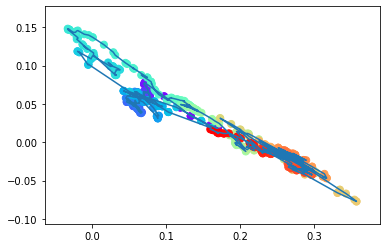

In [31]:
# look at state space

path_to_encoder = "../experiments/pixel_pendulum/2021/encoder_policy_joint/repnet"
pred = torch.load(path_to_encoder)
d = 5
proj = np.eye(d)

env = RestartablePendulumEnv(repeats=3,pixels=True)
env = ew.TorchEncoderWrapper(env,pred.encoder,proj)

n_samps = 500
for vel in [0]:
    X = np.empty((n_samps,d))
    for i,p in enumerate(np.linspace(-np.pi,np.pi,n_samps)):
        X[i,:] = env.reset(state=[p,vel])
    svd = TruncatedSVD(n_components=2)
    xhat = svd.fit_transform(X)
    colors = cm.rainbow(np.linspace(0,1,X.shape[0]))
    plt.scatter(xhat[:,0],xhat[:,1],s=50,c=colors)
    plt.plot(xhat[:,0],xhat[:,1])#,c=colors)    

plt.show()

In [17]:
# load a saved model -- must use the algorithm class for with which the model was trained
model = PPO2.load("../experiments/pixel_pendulum/2021/encoder_policy_joint/model")





Instructions for updating:
Use keras.layers.flatten instead.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




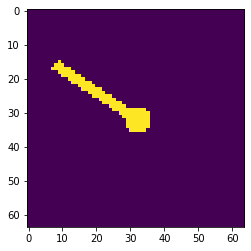

In [24]:
# make a gif of policy in action
ims = []
fig = plt.figure()
ob = env.reset()
for _ in range(200):
    a = model.predict(ob,deterministic=True)[0]
    ob,rew,done,info = env.step(a)
    ims.append([plt.imshow(env.env._get_pixels()[0,:,:],animated=True)])

ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                    repeat_delay=1000)

writer = PillowWriter(fps=20)
ani.save("demo.gif", writer=writer)

In [ ]:
# try to find a good linear policy by random sampling
# find a good random policy for pendulum
path_to_encoder = "../experiments/pixel_pendulum/2021/encoder_policy_joint/repnet"
pred = torch.load(path_to_encoder)
d = 5
proj = np.eye(d)

repeats = 3
env = RestartablePendulumEnv(repeats=repeats,pixels=True)
env = ew.TorchEncoderWrapper(env,pred.encoder,proj)


n = env.observation_space.shape[0]
z = env.reset(state=[0,0])
angs = np.linspace(-np.pi, np.pi, 5)[:-1]
vels = np.linspace(-8, 8, 5)
test_states = np.array(list(itertools.product(angs,vels)))
n_test_states = len(angs)*len(vels)
n_test_steps = int(100) # 100 steps in the underlying system
# try random policies
best = -np.inf
for i in range(500):
    K = 10*np.random.rand(1)*np.random.uniform(low=-1,high=1,size=(1,n))
    bias = np.dot(K,z)
    performance = np.zeros(n_test_states)
    for k in range(n_test_states):
        obs = env.reset(state=test_states[k])
        rewards = []
        for j in range(int(n_test_steps)):
            a = -np.dot(K,obs)+bias
            obs, reward, dones, info = env.step(a)
            rewards.append(reward/3)
        performance[k] = np.array(rewards).mean()
    if performance.mean() > best:
        best = performance.mean()
        best_k = K
        best_bias = bias
    if (i+1)%10 == 0:
        print(best)
K = best_k
bias = best_bias
print(best)

-4.71659042288664
-4.71659042288664
